# Building a Portfolio - Pairs Trading and Statistical Arbitrage in R 

## Motivation

**Goal:** Buy the *undervalued* security while short-selling the *overvalued* security, all while maintaining market neutrality.

**Companies:** in the same sector that are likely to be exposed to similar market factors. Occasionally, their relative stock prices will diverge due to certain events, however, they will revert to the long-run mean, i.e. mean-reverting stocks.

**Systematic Risk and Market-Neutral Strategies:** pairs trading can reduce the market risk, as two risky positions taken together can effectively eliminate market risk.

**Example of Pairs:** 

- Commodities (gold and the stock of gold mines, oil and the stocks of oil producer companies)

## Correlation in R

In [17]:
library(tseries)
library(quantmod)
library(PerformanceAnalytics)
library(urca)
library(roll)

Warning message:
"package 'roll' was built under R version 3.6.2"

### Build a Portfolio with Two Stocks (PEP, KO) 

Get the data from Yahoo Finance

In [24]:
# Pepsi and Coca-Cola Stocks

my_portfolio <- c("PEP", "KO")

# Apply the get symbols on the list of company tickers
stocks <- lapply(my_portfolio, getSymbols, auto.assign = FALSE)

# Assign as index names of the stocks the list of company tickers
names(stocks) <- my_portfolio

head(stocks$PEP)

           PEP.Open PEP.High PEP.Low PEP.Close PEP.Volume PEP.Adjusted
2007-01-03    62.70    63.35   62.45     62.72    6161600     42.84473
2007-01-04    62.70    63.25   62.50     63.15    5414300     43.13848
2007-01-05    62.70    63.22   62.70     62.95    4542400     43.00184
2007-01-08    63.00    63.27   62.86     63.09    6122600     43.09748
2007-01-09    63.05    63.47   63.01     63.35    4916500     43.27508
2007-01-10    63.00    64.29   62.29     64.15    6427100     43.82156

**Adjusted closing price** get from the datasets

**Returns** create a data series for each stock with their respective daily returns

In [26]:
# Adjusted close of Pepsi
pep <- stocks[[my_portfolio[1]]][,6]

# Adjusted close of Coca-Cola
ko <- stocks[[my_portfolio[2]]][,6]

# Get return Pepsi
return_pep <- dailyReturn(pep, type = "arithmetic")

# Get return Coca-Cola
return_ko <- dailyReturn(ko, type = "arithmetic")

# Set the column names of the two stocks
colnames(return_pep) = "Pepsi Returns"
colnames(return_ko) = "Coca-Cola Returns"

head(return_pep)

           Pepsi Returns
2007-01-03   0.000000000
2007-01-04   0.006856153
2007-01-05  -0.003167358
2007-01-08   0.002223974
2007-01-09   0.004121007
2007-01-10   0.012628099

**Calculate the correlation** between the two stocks

**plot the cumulative returns** by using the combined data set

,Pepsi Returns
Coca-Cola Returns,0.6802405


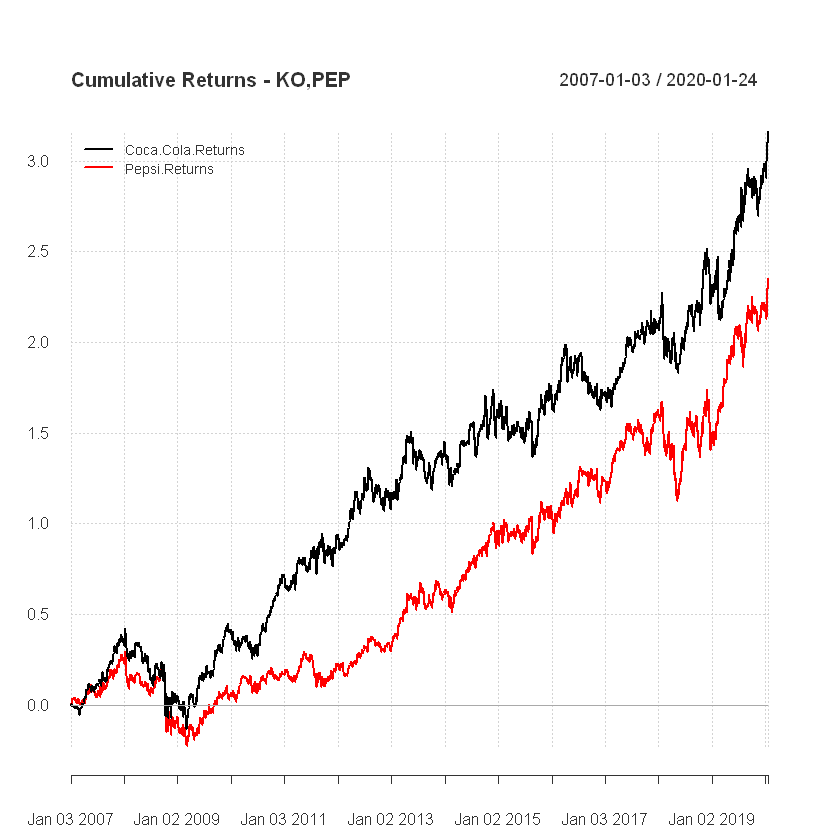

In [32]:
# Calculate the Covariance
cor(return_ko, return_pep)

# Plot the daily returns
chart.CumReturns(cbind(return_ko, return_pep), main = "Cumulative Returns - KO,PEP",
                legend.loc = "topleft")

Given the cumulative returns chart, there is a degree of correlation between the two assets and as we can see from our calculations, the correlation is: $\rho = 0.6816855$, therefore, there is positive correlation between the two assets.

## Cointegration Analysis

We are interested in the long-term relationship betwen the two assets, therefore, we look for the co-movement or cointegrating relationship.

**Goal:** to make sure that the paired assets prices spread mean is constant through time.

<p style="text-align:center;"> $\text{Linear Regression: } s_t = y_t - \beta x_t$ </p>

So we us the Pepsi ($x_t$) adjusted closing prices and the Coca-Cola ($y_t$) adjusted closing prices in the regression. Given the high correlation coefficient, there is some linear relationship between the prices and **the $\beta$ value is the result of the regression.**

**Calculating the spread** we can calculate the *s* spread based on the formula above.

- If we consider the spread, it performs periodical oscillations around some mean value
- Using this pair, we know that the spread will return to its average value with high probability

### XTS:

Create Or Test For An xts Time-Series Object Description.

Constructor function for creating an extensible time-series object.

xts is used to create an xts object from raw data inputs.

**Usage:**

```
xts(x = NULL,
    order.by = index(x),
    frequency = NULL,
    unique = TRUE,
    tzone = Sys.getenv("TZ"),
    ...)

is.xts(x)
```
**Arguments:**

```x```	 an object containing the time series data

```order.by``` a corresponding vector of unique times/dates - must be of a known time-based class. See details.

```frequency```	 numeric indicating frequency of order.by. See details.

```unique```	 should index be checked for unique time-stamps?

```tzone```	 time zone of series. This is ignored for Date indices

```...``` additional attributes to be added. See details.


**In this case:**

the ```x``` will be equal to the mean of the spread, repeated as many times as the length of the spread array.

In [39]:
# The spread can be calculated based on Linear Regression
spread <- pep - lm(pep ~ 0 + ko)$coefficients[1]*ko

# There is some oscillation around the mean of the spread
## This creates a vector of identical spread means
spread_mean <- xts(rep(mean(spread), length(spread)), order.by=as.Date(index(spread)))
head(spread_mean)

                 [,1]
2007-01-03 0.00909688
2007-01-04 0.00909688
2007-01-05 0.00909688
2007-01-08 0.00909688
2007-01-09 0.00909688
2007-01-10 0.00909688

### Plot the Spread

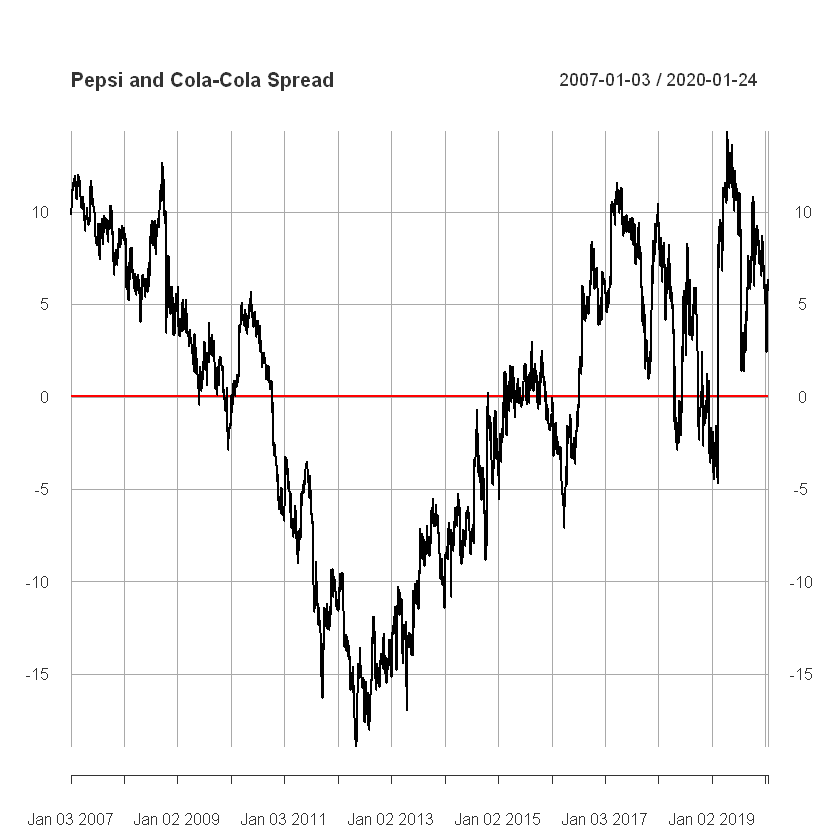

In [43]:
# Plotting the spread and its mean
plot(cbind(spread, spread_mean), main = "Pepsi and Cola-Cola Spread")

## Using Engle-Granger Cointegration Test

To test whether two paired assets' prices linear regression residuals, **i.e. the spread** are stationary. 

- Since the single stock prices (PEP and KO) are non-stationary
    - we have to make sure their spread is stationary (asset's price differences)
    
### ADF Test:

**IF $\beta$ IS KNOWN:**

In [44]:
# Augmented Dickey Fuller Test
adf.test(spread)
# Phillips-Perron Test
pp.test(spread, lshort=F)


	Augmented Dickey-Fuller Test

data:  spread
Dickey-Fuller = -2.2338, Lag order = 14, p-value = 0.4793
alternative hypothesis: stationary



	Phillips-Perron Unit Root Test

data:  spread
Dickey-Fuller Z(alpha) = -8.93, Truncation lag parameter = 28, p-value
= 0.6117
alternative hypothesis: stationary


## Conclusion

The p-values of both tests indicate no cointegration since they do not reject the initial hypothesis as they are greater than $0.05$